In [1]:
import sys
sys.path.append('..')

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.patches as mpatches

from scipy.stats import entropy
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.feature_selection import f_regression

from trickster.wfp_helper import load_data, extract

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

matplotlib.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
#       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]

sns.set_context('paper', font_scale=2.5)

## Load the small WFP models

Each 'small model' trained on a small subset of 100 random traces.

In [4]:
NUM_MODELS = 100

In [158]:
model_pickle_names = ['../models/small_model_{}.pkl'.format(i) for i in range(1, NUM_MODELS+1)]
models = [pickle.load(open(filename, 'rb')) for filename in model_pickle_names]

coefs = np.array([model.coef_[0, 4:] for model in models])

coefs_norm = []
for coef_vec in coefs:
    coef_vec_norm = coef_vec / np.sum(np.abs(coef_vec))
    coefs_norm.append(coef_vec_norm + np.abs(np.min(coef_vec_norm)))
    
coefs_norm = np.array(coefs_norm)

We want to compare their coefficient vectors. Some of them have the coefficients rather monotone and smooth, others are changing more abruptly.

We measure the abruptness of change of coefficients using statistical entropy, and log-deviation of neighbour differences.

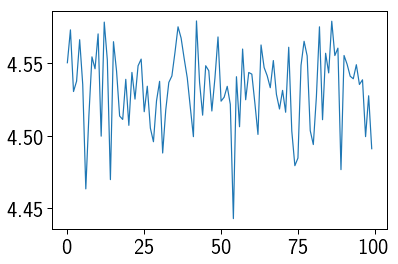

In [160]:
entropies = np.array([entropy(coef) for coef in coefs_norm])
plt.plot(entropies)
plt.show()

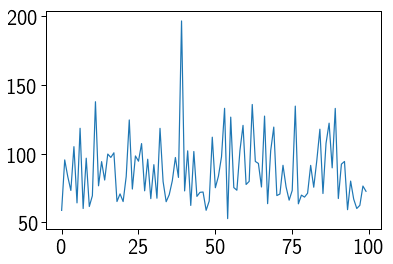

In [161]:
sharpness = np.array([-np.log10(np.ediff1d(coef).std()) for coef in coefs_norm])
# sharpness = np.array([np.ediff1d(coef).std() for coef in coefs_norm])
plt.plot(10 ** sharpness)
plt.show()

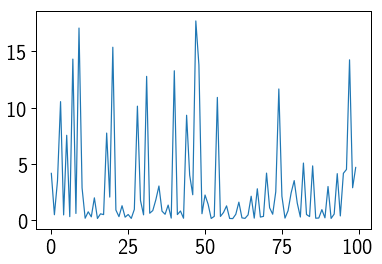

In [162]:
coef_vec_norms = np.array([np.linalg.norm(coef_vec, ord=1) for coef_vec in coefs])
plt.plot(coef_vec_norms)
plt.show()

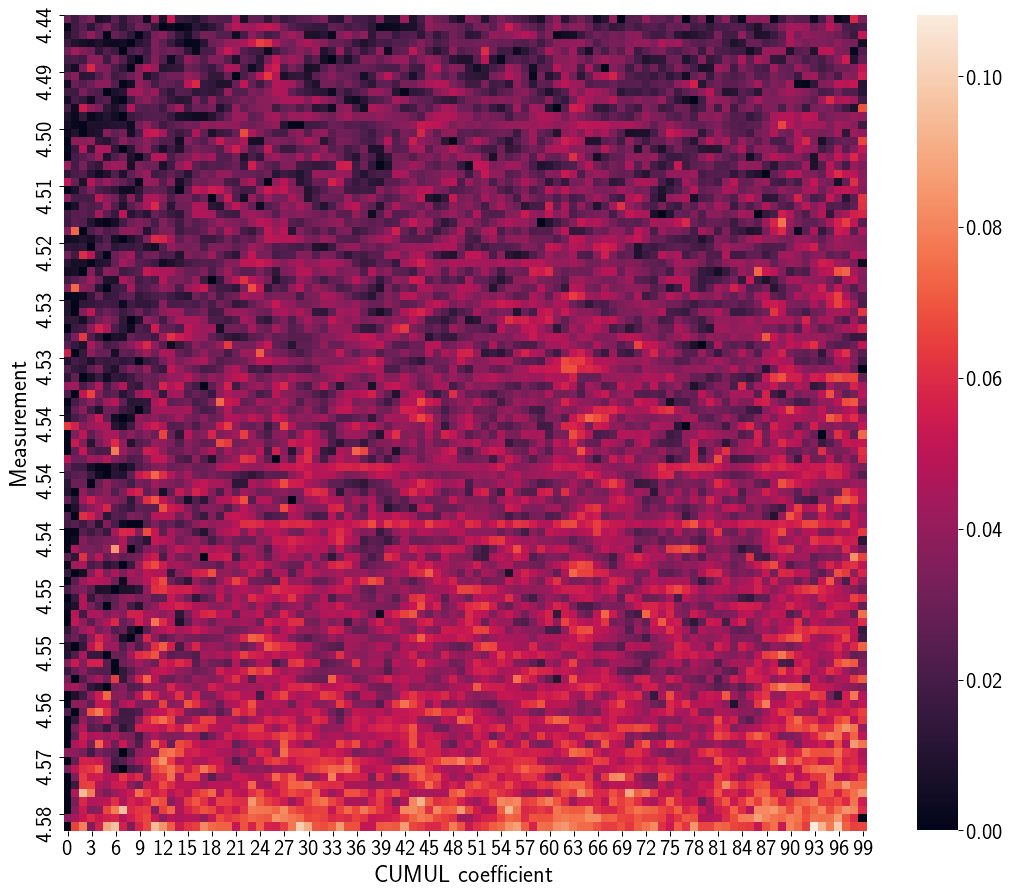

In [207]:
factors = np.array(entropies)

sorted_indices = list(range(len(coefs)))
sorted_indices.sort(key=lambda i: factors[i])
sorted_indices = np.array(sorted_indices)

coefs_sorted = coefs_norm[sorted_indices, :]

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(15)

sns.heatmap(coefs_sorted, ax=ax)

ticks = range(0, len(sorted_indices), 7)

ax.set_yticks(ticks)
ax.set_yticklabels(['%1.2f' % x for x in factors[sorted_indices[ticks]]])
ax.set_ylabel('Measurement')
ax.set_xlabel('CUMUL coefficient')
ax

## Load the reports on generated adversarial examples against the models`

In [229]:
adv_results_pickle_names = ['../out/results_small_model_{}.pkl'.format(i)
                            for i in range(1, NUM_MODELS+1)]
adv_results = [pd.read_pickle(filename) for filename in adv_results_pickle_names]

Compute the adverage success rate for each model (the iteration limit was 100 expansions).

In [230]:
success_rates = []
for results_df in adv_results:
    rate = results_df.found.mean()
    success_rates.append(rate)

And the average number of graph node expansions for each model.

In [231]:
exp_counts = []
for results_df in adv_results:
    count = results_df[results_df.found].nodes_expanded.mean()
    exp_counts.append(count)

In [232]:
def r2(x, y):
    """R^2 statistic."""
    return pearsonr(x, y)[0] ** 2

def f_test_p_value(x, y):
    """p-value of the F-test."""
    f_stat, p_value = f_regression(np.expand_dims(x, 1), y)
    return p_value[0]

In [172]:
def regplot(x, y, xlabel, ylabel, xlim=None, ylim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if xlim is None:
        xlim = min(x), max(x)
    if ylim is None:
        ylim = min(y), max(y)
        
    g = sns.regplot(x, y, ax=ax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    dummy = mpatches.Patch(color=(1, 1, 1, 1), label='p=%1.2e' % f_test_p_value(x, y))
    ax.legend(handles=[dummy])
    return ax

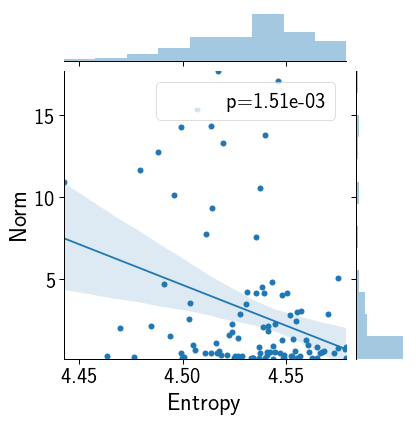

In [177]:
jp = sns.jointplot(entropies, coef_vec_norms)
regplot(entropies, coef_vec_norms,
        xlabel='Entropy', ylabel='Norm', ax=jp.ax_joint)


In [239]:
factors = entropies
factors_label = 'Grad entropies'

## Visualizing model robustness

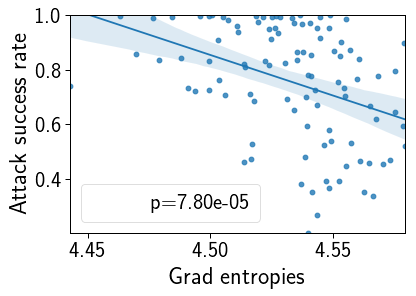

In [242]:
ax = regplot(factors, success_rates,
        xlabel=factors_label,
        ylabel='Attack success rate')

# ax.set_xscale('log')

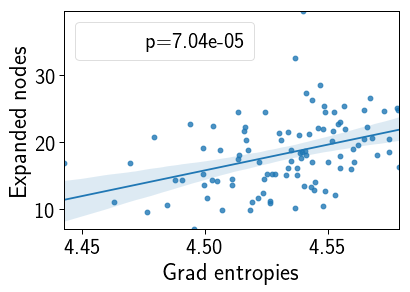

In [243]:
ax = regplot(factors, exp_counts,
        xlabel=factors_label,
        ylabel='Expanded nodes')

# ax.set_xscale('log')

## Check if the accuracy is not a hidden factor

In [ ]:
X, y = load_data('../data/knndata')
X_features = np.array([extract(trace) for trace in X])

In [108]:
perfs = [model.score(X_features, y) for model in models]

The poor fit shows that the accuracy of a model is likely not the reason why attack performs differently.

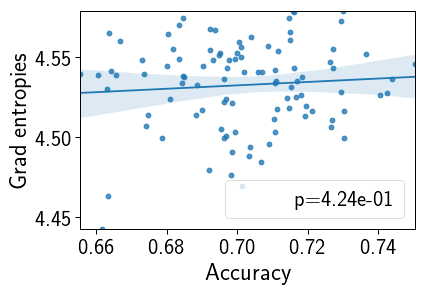

In [244]:
regplot(perfs, factors,
        xlabel='Accuracy',
        ylabel=factors_label)

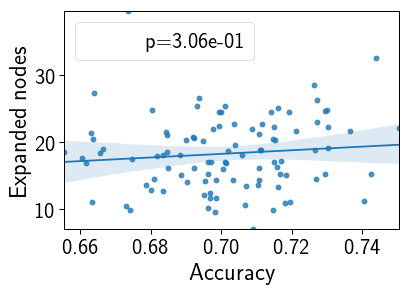

In [245]:
regplot(perfs, exp_counts,
        xlabel='Accuracy',
        ylabel='Expanded nodes')

In [197]:
conf_values = [np.quantile(model.predict_proba(X_features)[:, 1], .5) for model in models]

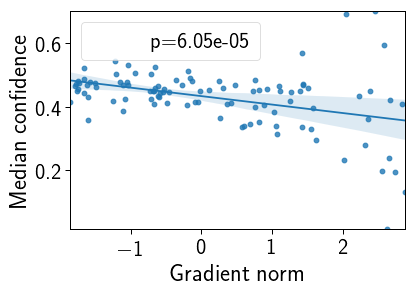

In [212]:
regplot(np.log(coef_vec_norms), conf_values,
        xlabel='Gradient norm', ylabel='Median confidence')

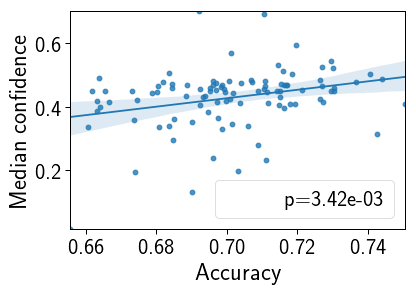

In [216]:
regplot(perfs, conf_values,
        xlabel='Accuracy', ylabel='Median confidence')